In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

os.environ["PATH"] += os.pathsep + '/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux'
print(os.getenv("PATH"))
latex_preamble = """
\\usepackage[utf8]{inputenc}
\\usepackage{microtype}
\\usepackage{amsmath}
\\renewcommand{\\rmdefault}{ptm}
\\renewcommand{\\sfdefault}{phv}
"""
fs = 9
column_width = 3.3249219444  # inch
text_width = 7.02625  # inch
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": latex_preamble,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "font.size": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "savefig.bbox": "tight",
})


/home/i40/cribeiro/anaconda3/envs/subsel_torch/bin:/home/i40/cribeiro/anaconda3/condabin:/home/i40/cribeiro/.vscode-server/bin/8b3775030ed1a69b13e4f4c628c612102e30a681/bin/remote-cli:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/usr/local/cuda/bin:/home/i40/cribeiro/usr/local/texlive/2024/bin/x86_64-linux


In [8]:
import pandas as pd
df = pd.read_csv('experiments/Synthetic/table_result.csv',index_col=0)

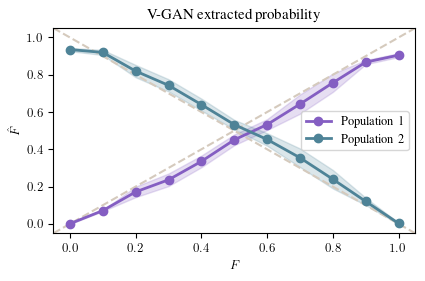

In [10]:

df_grouped = df.groupby('frac').agg(['mean', 'std'])
import matplotlib.pyplot as plt

x = df_grouped.index
p1_mean = df_grouped['p1']['mean']
p1_std = df_grouped['p1']['std']
p2_mean = df_grouped['p2']['mean']
p2_std = df_grouped['p2']['std']

plt.figure(figsize=(2*7/3, 2*4/3))
plt.axline((0, 0), linestyle = "--",slope=1, color = "#D5CABD", linewidth = 1.5)
plt.axline((0, 1), linestyle = "--",slope=-1, color = "#D5CABD", linewidth = 1.5)

plt.plot(x, p1_mean, label='Population 1', marker='o', linewidth = 2, color = '#845EC2')
plt.fill_between(x, p1_mean - p1_std, p1_mean + p1_std, color='#845EC2', alpha=0.2)

plt.plot(x, p2_mean, label='Population 2', marker='o', linewidth = 2, color = '#4E8397')
plt.fill_between(x, p2_mean - p2_std, p2_mean + p2_std, color='#4E8397', alpha=0.2)


plt.title('V-GAN extracted probability')
plt.xlabel('$F$')
plt.ylabel('$\\hat{F}$')
plt.legend()

plt.savefig("experiments/Synthetic/vgan_experiment.png", dpi=1000)
plt.show()

In [159]:
import numpy as np 
import pandas as pd
from typing import Union
import torch_two_sample as tts
from sklearn.preprocessing import normalize
import torch
from src.models.Mmd_loss_constrained import MMDLossConstrained

def check_if_myopic( x_data: np.array, bandwidth: Union[float, np.array] = 0.01, count=500) -> pd.DataFrame:
        """_summary_

        Args:
            x_data (np.array): Data to check the myopicity of.
            bandwidth (float | np.array, optional): Bandwidth used in the GOF tests using the MMD. This method always runs
            the recommended bandwidth alongside this optional one. Defaults to 0.01.
            count (int, optional): Number of samples used to approximate the MMD. Defaults to 500.

        Returns:
            pd.DataFrame: DataFrame containing the p.value of the test with all the different bandwidths.
        """
        assert count <= x_data.shape[0], "Selected 'count' is greater than the number of samples in the dataset"
        results = []

        x_data = normalize(x_data, axis=0)
        x_sample = torch.Tensor(pd.DataFrame(
            x_data).sample(count).to_numpy()).to('cuda')
        x_sample2 = torch.Tensor(pd.DataFrame(
            x_data).sample(count).to_numpy()).to('cuda')
        u_subspaces = torch.BoolTensor(np.append(np.repeat([[True,True,False]],int(x_sample.shape[0]/2),axis=0),np.repeat([[False,False,True]],x_sample.shape[0]-int(x_sample.shape[0]/2),axis=0),axis=0)).to('cuda')
        ux_sample = u_subspaces * \
            torch.Tensor(x_sample).to('cuda') + \
            torch.mean(x_sample2, dim=0)*(~u_subspaces)
        

        mmd_loss = MMDLossConstrained(0)
        mmd_loss.forward(
                x_sample, ux_sample, u_subspaces*1)
        bandwidth = mmd_loss.bandwidth

        bw = bandwidth.item()
        mmd = tts.MMDStatistic(count, count)
        _, distances = mmd(x_sample, ux_sample, alphas=[
            bw], ret_matrix=True)
        results.append(mmd.pval(distances))

        return pd.DataFrame([results], columns=[bandwidth.item()], index=["p-val"])


In [161]:
from src.modules.synthetic_module import generate_data_3d

x_data = generate_data_3d(.5,500,seed=np.random.random_integers(10,10000))
check_if_myopic(x_data,count=500)


/tmp/ipykernel_442942/2867346180.py:3: DeprecationWarning: This function is deprecated. Please call randint(10, 10000 + 1) instead
  x_data = generate_data_3d(.5,500,seed=np.random.random_integers(10,10000))


,0.194404
p-val,1.0
